# Scratch work for TensorFlow skills test (image recognition)

- Author: Chris Hodapp
- Date: 2017-11-28
- For SharpestMinds/Yazabi

## Links:

- [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers)
  - Using [train_32x32.mat](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) and [test_32x32.mat](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) in `./data` directory
- AlexNet
  - [ImageNet Classification with Deep Convolutional Neural Networks (slides)](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf)
  - [ImageNet Classification with Deep Convolutional Neural Networks (paper)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
  - https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py#L231
  - https://dandxy89.github.io/ImageModels/alexnet/
  - [Local Response Normalization (LRN)](https://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/#Local-Response-Normalization-LRN)
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://keras.io/preprocessing/image/
- https://github.com/amir-abdi/keras_to_tensorflow/blob/master/keras_to_tensorflow.ipynb
- https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html


In [1]:
import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dropout, Flatten, Input, merge, Dense, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

Using TensorFlow backend.


# Data Loading

In [2]:
train = scipy.io.loadmat("data/train_32x32.mat")
test = scipy.io.loadmat("data/test_32x32.mat")

In [3]:
train_X, train_y = train["X"], train["y"].squeeze()
test_X, test_y = test["X"], test["y"].squeeze()

In [4]:
train_X.shape, train_y.shape

((32, 32, 3, 73257), (73257,))

In [5]:
test_X.shape, test_y.shape

((32, 32, 3, 26032), (26032,))

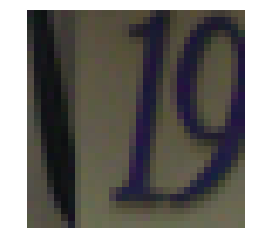

In [6]:
plt.imshow(train_X[:, :, :, 0])
plt.axis('off')
plt.show()

In [7]:
def stack_rgb(img):
    imgs = (img[:, :, 0], img[:, :, 1], img[:, :, 2])
    return np.concatenate(imgs, axis=1)

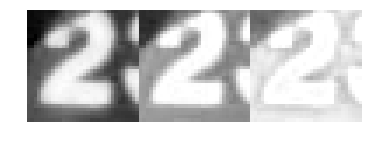

In [8]:
plt.imshow(stack_rgb(train_X[:, :, :, 2]), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Standard NTSC/PAL luminance:
train_X_lum = 0.2989*train_X[:,:,0,:] + 0.5870*train_X[:,:,1,:] + 0.1140*train_X[:,:,2,:]
test_X_lum = 0.2989*test_X[:,:,0,:] + 0.5870*test_X[:,:,1,:] + 0.1140*test_X[:,:,2,:]

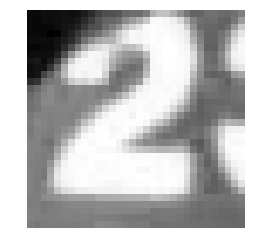

In [10]:
plt.imshow(train_X_lum[:, :, 2], cmap='gray')
plt.axis('off')
plt.show()

My guess:
- Luminance is meant to approximate the brightness we actually see. Images with similar luminance in foreground and background, but different colors, are probably then unlikely: it's just hard to read, and typically also ugly.
- However, color could still be a helpful proxy to help with foreground/background.

In [11]:
def normalize(images):
    """Converts input images to greyscale, and normalizes them
    (i.e. zero mean & unit variance for each pixel coordinate);
    returns a new array of images with shape (Y,X,N).
    
    Parameters:
    images -- Input array, shape (Y,X,3,N), for N color XxY images
    """
    r, g, b = images[:,:,0,:], images[:,:,1,:], images[:,:,2,:]
    img_lum = 0.2989*r + 0.5870*g + 0.1140*b
    # Note the axis=2. This normalization is per-pixel (though since
    # every pixel has been normalized, the aggregate mean & stdev
    # are also 0 and 1)
    mean = img_lum.mean(axis=2)[:,:,np.newaxis]
    stdev = img_lum.std(axis=2)[:,:,np.newaxis]
    img_norm = (img_lum - mean) / stdev
    return img_norm

In [12]:
train_X_norm = normalize(train_X)
train_X_norm.mean(), train_X_norm.std()

(1.0490779352118218e-15, 0.99999999999999878)

In [13]:
train_y.max()

10

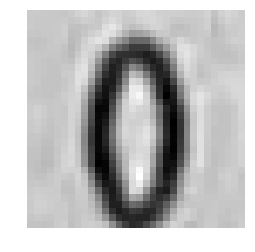

In [14]:
plt.imshow(train_X_lum[:,:,train_y == 10][:,:,4], cmap='gray')
plt.axis('off')
plt.show()

In [15]:
# Label of 10 appears to be the same as label of 0?
train_y[train_y == 10] = 0
train_y.max()

9

In [16]:
# Little lopsided (1 occurs 3 times as often as 0, 8, and 9):
for i in range(train_y.max() + 1):
    count = (train_y == i).sum()
    print("{0}: {1} ({2:.1f}%)".format(i, count, 100.0 * count / train_y.size))

0: 4948 (6.8%)
1: 13861 (18.9%)
2: 10585 (14.4%)
3: 8497 (11.6%)
4: 7458 (10.2%)
5: 6882 (9.4%)
6: 5727 (7.8%)
7: 5595 (7.6%)
8: 5045 (6.9%)
9: 4659 (6.4%)


## TensorFlow/Keras tests

- First tests were with 4096 units in the two dense layers at the end.  This got to ~0.93 validation accuracy in 5 or 6 epochs.
- However, it seems unnecessary.  I can replace with 256 or 512 units and see (at least in a few tests) no apparent degradation of accuracy.
- Likewise, the first convolutional layer was dropped, and the sizes of the other layers was cut in half (down to 128, 192, 192, 128) with seemingly no drawback.
- Anecdotally: It seems to train more slowly with the smaller networks with regard to number of epochs required.
- The size of the h5 dumps is worth looking at though. For the original network (AlexNet without the initial convolutional layer), it's 147 MB. For 128/196/196/128/256/256, it's about 8 MB - for basically the same performance.
- I can remove one of the middle convolutional layers (e.g. `conv_4`) and this speeds up training (in terms of wall clock time), but still is able to get to ~0.93.
- If I remove another, the time spent is even less, but it seems to converge more slowly and to less-accurate results.  Validation loss starts to increase - indicating overfitting, I guess, but why would a lower-capacity network overfit more easily?

### Greyscale

In [17]:
# Some local modules are imported as I started moving code out of
# the notebook:
import data_preprocessing
import learn
import graph_construction

In [18]:
from tensorflow.python.client import device_lib

for x in device_lib.list_local_devices():
    print("{0.name}, {0.device_type}, {0.memory_limit}".format(x))

/cpu:0, CPU, 268435456
/device:XLA_CPU:0, XLA_CPU, 17179869184
/device:XLA_GPU:0, XLA_GPU, 17179869184
/device:XLA_EXEC:0, XLA_EXEC, 17179869184
/gpu:0, GPU, 5650120704


In [19]:
train_X_orig, train_y_orig, _, _ = data_preprocessing.load_data()
train_X_norm = data_preprocessing.normalize_greyscale(train_X_orig)
train_X, valid_X, train_y, valid_y = data_preprocessing.split(
    train_X_norm, train_y_orig)
# 'split' is deterministic. If we want to look at the images later,
# we can pass the un-normalized ones in and it will correspond with
# the same split:
train_X_unnorm, valid_X_unnorm, _, _ = data_preprocessing.split(
    train_X_orig, train_y_orig)

In [20]:
# Adapted from:
# https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/customlayers.py#L9
def lrn(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    def f(X):
        b, r, c, ch = X.shape
        half = n // 2
        square = keras.backend.square(X)
        # TODO: Fix padding here. The scale += ... line is failing.
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0, 0), (half, half)))
        extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:, :, :, i:i + int(ch)]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [21]:
def AlexNet_shallower(input_shape=(32, 32, 1), output_count=10, use_dropout=True):
    inputs = Input(shape=input_shape)

    #conv_1 = Conv2D(96, kernel_size=(11,11), strides=(4, 4), activation='relu', name='conv_1')(inputs)

    #conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1)
    #conv_2 = lrn(name='convpool_1')(conv_2)
    #conv_2 = ZeroPadding2D((2, 2))(conv_2)
    #conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(conv_2)
    conv_2 = Conv2D(128, kernel_size=(5,5), activation='relu', name='conv_2')(inputs)
    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = lrn()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Conv2D(192, kernel_size=(3, 3), activation='relu', name='conv_3')(conv_3)
    conv_4 = ZeroPadding2D((1, 1))(conv_3)
    conv_4 = Conv2D(192, kernel_size=(3, 3), activation='relu', name='conv_4')(conv_4)
    conv_5 = ZeroPadding2D((1, 1))(conv_4)
    conv_5 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv_5')(conv_5)
    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name='convpool_5')(conv_5)
    dense_1 = Flatten(name='flatten')(dense_1)
    dense_1 = Dense(256, activation='relu', name='dense_1')(dense_1)
    if use_dropout:
        dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(256, activation='relu', name='dense_2')(dense_2)
    if use_dropout:
        dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(output_count, name='dense_3')(dense_3)
    prediction = Activation('softmax', name='softmax')(dense_3)

    model = Model(inputs=[inputs], outputs=[prediction])

    return model

In [22]:
alex = AlexNet_shallower()

In [23]:
# One-hot encode so they can be used for input/validation:
train_y_cat = keras.utils.to_categorical(train_y, num_classes=10)
valid_y_cat = keras.utils.to_categorical(valid_y, num_classes=10)

In [24]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alex.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [25]:
train_X2 = np.expand_dims(train_X, axis=3)
valid_X2 = np.expand_dims(valid_X, axis=3)

history = learn.BatchHistory(valid_X2, valid_y_cat, skip=40)

# 'history' in callbacks slows things down considerably
# as it must test repeatedly on the whole validation set
alex.fit(train_X2, train_y_cat, epochs=20,
         batch_size=64, callbacks=[history],
         validation_data=(valid_X2, valid_y_cat))

Train on 54942 samples, validate on 18315 samples
Epoch 1/20
54942/54942 [==============================] - 116s - loss: 1.3858 - acc: 0.5267 - val_loss: 0.5252 - val_acc: 0.8393
Epoch 2/20
54942/54942 [==============================] - 120s - loss: 0.5021 - acc: 0.8512 - val_loss: 0.3498 - val_acc: 0.8968
Epoch 3/20
  384/54942 [..............................] - ETA: 601s - loss: 0.4143 - acc: 0.8750

/nix/store/pvg79hnl59wh57k4kfw9qjqpvahxza1a-python3-3.6.3-env/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.017190). Check your callbacks.
  % delta_t_median)


54942/54942 [==============================] - 124s - loss: 0.3803 - acc: 0.8903 - val_loss: 0.3039 - val_acc: 0.9115
Epoch 4/20
54942/54942 [==============================] - 120s - loss: 0.3205 - acc: 0.9079 - val_loss: 0.3152 - val_acc: 0.9100
Epoch 5/20
54942/54942 [==============================] - 121s - loss: 0.2850 - acc: 0.9198 - val_loss: 0.2930 - val_acc: 0.9150
Epoch 6/20
54942/54942 [==============================] - 116s - loss: 0.2582 - acc: 0.9273 - val_loss: 0.2580 - val_acc: 0.927892 - ETA: 5s - loss:
Epoch 7/20
54942/54942 [==============================] - 120s - loss: 0.2301 - acc: 0.9353 - val_loss: 0.2443 - val_acc: 0.9339
Epoch 8/20
54942/54942 [==============================] - 116s - loss: 0.2116 - acc: 0.9405 - val_loss: 0.2558 - val_acc: 0.9317
Epoch 9/20
54942/54942 [==============================] - 120s - loss: 0.1974 - acc: 0.9446 - val_loss: 0.2604 - val_acc: 0.9302
Epoch 10/20
54942/54942 [==============================] - 111s - loss: 0.1768 - acc: 0.

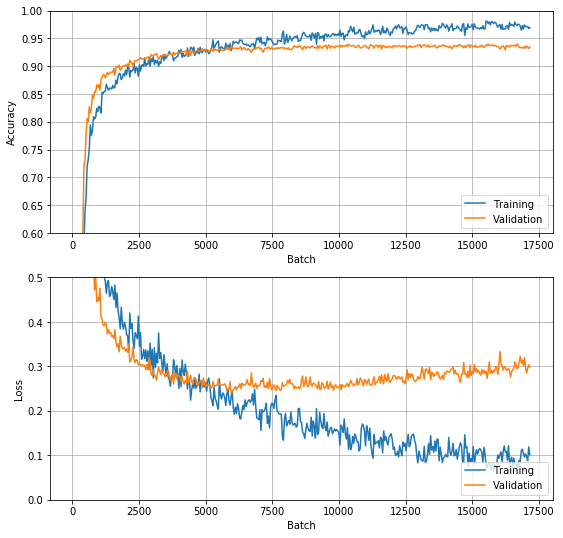

In [26]:
h = history.history
b = [i["batch"] for i in h]

plt.figure(figsize=(9,9))
series = [(1, "acc", "val_acc", "Accuracy", [0.6, 1.0]),
          (2, "loss", "val_loss", "Loss", [0, 0.5])]
for plotnum,d0,d1,yname,ylim in series:
    plt.subplot(2, 1, plotnum)
    plt.plot(b, [i[d0] for i in h])
    plt.plot(b, [i[d1] for i in h])
    plt.ylim(ylim)
    plt.ylabel(yname)
    plt.xlabel("Batch")
    plt.grid()
    plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [27]:
alex.save_weights('alexnet_smaller_20171130.h5')

In [28]:
valid_y_predict = np.argmax(alex.predict(valid_X2), axis=1)
# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict)
conf = pd.DataFrame(conf, columns=range(10), index=range(10))
conf

,0,1,2,3,4,5,6,7,8,9
0,1165,27,6,4,5,0,11,4,3,12
1,17,3312,13,22,38,6,8,31,10,8
2,3,26,2505,22,22,6,9,31,4,18
3,3,18,18,1962,20,53,4,19,15,12
4,5,35,7,13,1780,4,7,5,3,6
5,1,10,5,54,7,1589,18,7,5,25
6,11,8,4,8,10,28,1326,3,24,10
7,3,34,20,10,5,2,1,1320,0,4
8,15,20,12,18,5,8,25,4,1132,22
9,12,13,18,10,18,9,6,4,9,1066


In [29]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

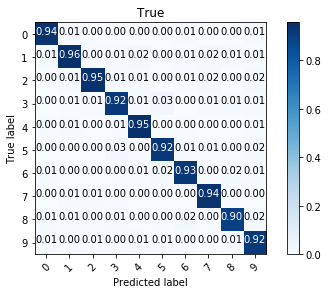

In [30]:
conf_norm = conf / conf.sum(axis=1)
plot_confusion_matrix(conf_norm.values, [str(i) for i in range(10)], True)
plt.show()

- It's also possible to show - in the same shape as the above matrix - an example of every misclassification:

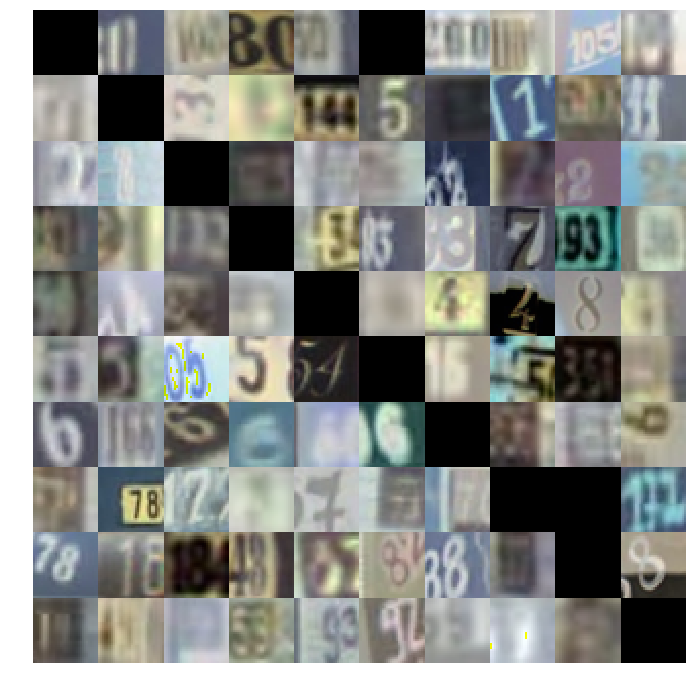

In [31]:
grid = np.zeros((32 * 10, 32 * 10, 3))
for i,j in [(i,j) for i in range(10) for j in range(10)]:
    # Leave diagonals blank (we don't care about correct ones):
    if i == j: continue
    # Find all cases where i is classified as j:
    idxs = ((valid_y == i) & (valid_y_predict == j)).nonzero()[0]
    # Pick one at random if one exists, and fill in grid:
    if idxs.size == 0: continue
    grid[(32*i):32*(i+1), (32*j):32*(j+1), :] = valid_X_unnorm[np.random.choice(idxs), :, :, :]
# I don't feel like wrangling matplotlib into showing this, so:
# Rows 0-9 are the correct labels.
# Columns 0-9 are the predicted labels.
plt.figure(figsize=(12,12))
plt.imshow(grid)
plt.axis('off')
plt.show()

Error classes:
- Multiple numbers
- Rotated, slanted, or sheared numbers
- Odd fonts, handwritten numbers
- Just too blurry to tell?

## Testing `graph_construction`

In [32]:
import graph_construction
#import imp
#graph_construction = imp.reload(graph_construction)

In [33]:
model, train_op, accuracy, x, y = graph_construction.classifier(0.02, True)

## Data Augmentation
- Based around [Keras Image Preprocessing](https://keras.io/preprocessing/image/), [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- Reasoning: This might help with some cases of the numbers being rotated or slanted; it may potentially also do better at partial matches if moving to one side or the other clips the image
- Results: This trains more slowly and isn't able to outperform the non-augmented case. With learning rate at 0.01, it seems to meander around, make progress, undo progress, and overall come close to the non-augmented case's accuracy but only with many more epochs.
- The ImageNet paper mentions (on p6) another augmentation approach that may be interesting to try based on faking different illumination intensity and color.

In [34]:
datagen = ImageDataGenerator(rotation_range=45, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
train_gen = datagen.flow(train_X2, train_y_cat, batch_size=64)

In [35]:
alex = AlexNet_shallower()

In [36]:
sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
alex.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [37]:
history = learn.BatchHistory(valid_X2, valid_y_cat, skip=40)

alex.fit_generator(train_gen, epochs=20,
         #callbacks=[history],
         steps_per_epoch=2000,
         validation_data=(valid_X2, valid_y_cat))

Epoch 1/20
2000/2000 [==============================] - 68s - loss: 2.2277 - acc: 0.1928 - val_loss: 2.0430 - val_acc: 0.2625
Epoch 2/20
2000/2000 [==============================] - 65s - loss: 1.9326 - acc: 0.3232 - val_loss: 1.1201 - val_acc: 0.6633
Epoch 3/20
2000/2000 [==============================] - 66s - loss: 1.4528 - acc: 0.5066 - val_loss: 0.6492 - val_acc: 0.8054
Epoch 4/20
2000/2000 [==============================] - 67s - loss: 1.1239 - acc: 0.6283 - val_loss: 0.4994 - val_acc: 0.8443
Epoch 5/20
2000/2000 [==============================] - 66s - loss: 0.9442 - acc: 0.6991 - val_loss: 0.4330 - val_acc: 0.8673
Epoch 6/20
2000/2000 [==============================] - 66s - loss: 0.8303 - acc: 0.7380 - val_loss: 0.3940 - val_acc: 0.8796
Epoch 7/20
2000/2000 [==============================] - 66s - loss: 0.7609 - acc: 0.7635 - val_loss: 0.3675 - val_acc: 0.8892
Epoch 8/20
2000/2000 [==============================] - 66s - loss: 0.7079 - acc: 0.7802 - val_loss: 0.3673 - val_acc:

## RGB

- This is experimenting to see if the architecture can get some additional accuracy out of full RGB images
- In a few tests it seems to require the larger (wider but not deeper?) network

In [38]:
def AlexNet(input_shape=(32, 32, 1), output_count=10, use_dropout=True):
    inputs = Input(shape=input_shape)

    #conv_1 = Conv2D(96, kernel_size=(11,11), strides=(4, 4), activation='relu', name='conv_1')(inputs)

    #conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1)
    #conv_2 = lrn(name='convpool_1')(conv_2)
    #conv_2 = ZeroPadding2D((2, 2))(conv_2)
    #conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(conv_2)
    conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(inputs)
    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = lrn()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_3')(conv_3)
    conv_4 = ZeroPadding2D((1, 1))(conv_3)
    conv_4 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_4')(conv_4)
    conv_5 = ZeroPadding2D((1, 1))(conv_4)
    conv_5 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv_5')(conv_5)
    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name='convpool_5')(conv_5)
    dense_1 = Flatten(name='flatten')(dense_1)
    dense_1 = Dense(512, activation='relu', name='dense_1')(dense_1)
    if use_dropout:
        dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(512, activation='relu', name='dense_2')(dense_2)
    if use_dropout:
        dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(output_count, name='dense_3')(dense_3)
    prediction = Activation('softmax', name='softmax')(dense_3)

    model = Model(inputs=[inputs], outputs=[prediction])

    return model

In [39]:
train_X_norm_RGB = data_preprocessing.normalize(train_X_orig)
train_X_rgb, valid_X_rgb, train_y_rgb, valid_y_rgb = data_preprocessing.split(
    train_X_norm_RGB, train_y_orig)

In [40]:
alex = AlexNet(input_shape=(32, 32, 3))

In [41]:
# One-hot encode so they can be used for input/validation:
train_y_cat = keras.utils.to_categorical(train_y, num_classes=10)
valid_y_cat = keras.utils.to_categorical(valid_y, num_classes=10)

In [42]:
sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
alex.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [43]:
history = learn.BatchHistory(valid_X_rgb, valid_y_cat, skip=40)

alex.fit(train_X_rgb, train_y_cat, epochs=20,
         batch_size=64, #callbacks=[history],
         validation_data=(valid_X_rgb, valid_y_cat))

Train on 54942 samples, validate on 18315 samples
Epoch 1/20
54942/54942 [==============================] - 78s - loss: 1.2035 - acc: 0.5936 - val_loss: 0.4757 - val_acc: 0.8624
Epoch 2/20
54942/54942 [==============================] - 77s - loss: 0.4249 - acc: 0.8723 - val_loss: 0.3115 - val_acc: 0.9095
Epoch 3/20
54942/54942 [==============================] - 76s - loss: 0.3266 - acc: 0.9048 - val_loss: 0.2881 - val_acc: 0.9161
Epoch 4/20
54942/54942 [==============================] - 76s - loss: 0.2723 - acc: 0.9220 - val_loss: 0.2567 - val_acc: 0.9274
Epoch 5/20
54942/54942 [==============================] - 77s - loss: 0.2329 - acc: 0.9328 - val_loss: 0.2679 - val_acc: 0.9284
Epoch 6/20
54942/54942 [==============================] - 76s - loss: 0.2032 - acc: 0.9437 - val_loss: 0.2498 - val_acc: 0.9315
Epoch 7/20
54942/54942 [==============================] - 76s - loss: 0.1815 - acc: 0.9494 - val_loss: 0.2322 - val_acc: 0.9384
Epoch 8/20
54942/54942 [==============================

- Above reaches validation loss of 0.2315 & accuracy of 0.9407 at 8 epochs... however, only an incremental improvement over what I could reach with greyscale.  I'm not sure if it's worth the extra number of parameters needed to get there.